# Atividade 3: Classificação de Lixo Doméstico

> Classificação de lixo doméstico utilizando Python e Keras.

## Desafio

Classificar alguns objetos encontrados em lixo doméstico usando o _dataset_ do Kaggle disponível em https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset/.
O conjunto de dados possui 6 classes (6 tipos de lixo):

- 📦 Caixas de papelão;
- 🥂 Vidro;
- 🛢️ Metal;
- 🗞️ Papel;
- 🥤 Plástico;
- 🗑️ Entulhos (restos de embalagem, comida e outros que não se enquadram nas categorias anteriores).

## Autores

- Orientadora: Elloá B. Guedes - [@elloa](https://github.com/elloa)
- Time:
  - Debora Souza Barros - [@Debby-Barros](https://github.com/Debby-Barros)
  - Diana Martins - [@ddianaom](https://github.com/ddianaom)
  - Gabriel Dos Santos Lima - [@gabrielSantosLima](https://github.com/gabrielSantosLima)
  - Thiago Marques - [@tmmarquess ](https://github.com/tmmarquess)


## Etapa 0: Configuração do ambiente

Os tópicos que serão abordados nesta etapa:
* Importação das bibliotecas
* Baixar o _dataset_ para o arquivo local do projeto  

In [1]:
!pip install optuna keras_tuner tensorflow[and-cuda] kaggle

  Preparing metadata (setup.py) ... - \ done
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.5/197.5 MB 8.0 MB/s eta 0:00:00


In [2]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import keras_tuner as kt

from collections import Counter
from glob import glob
from keras_tuner import HyperModel
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

2024-07-28 22:42:37.260927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 22:42:37.281547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 22:42:37.287905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# baixando do kaggle
if not os.path.isdir('dataset'):
  !rm -r sample_data
  !kaggle datasets download -d farzadnekouei/trash-type-image-dataset
  !unzip trash-type-image-dataset.zip
  !rm trash-type-image-dataset.zip
  !mv TrashType_Image_Dataset dataset
else:
  print("Conjunto de dados já existe no diretório atual.")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


rm: cannot remove 'sample_data': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset
License(s): unknown
 93%|████████████████████████████████████▏  | 38.0M/40.9M [00:00<00:00, 196MB/s]
100%|███████████████████████████████████████| 40.9M/40.9M [00:00<00:00, 194MB/s]
Archive:  trash-type-image-dataset.zip
  inflating: TrashType_Image_Dataset/cardboard/cardboard_001.jpg  
  inflating: TrashType_Image_Dataset/cardboard/cardboard_002.jpg  
  inflating: TrashType_Image_Dataset/cardboard/cardboard_003.jpg  
  inflating: TrashType_Image_Dataset/cardboard/cardboard_004.jpg  
  inflating: TrashType_Image_Dataset/cardboard/cardboard_005.jpg  
  inflating: TrashType_Image_Dataset/cardboard/cardboard_006.jpg  
  inflating: TrashType_Image_Dataset/cardboard/cardboard_007.jpg  
  inflating: TrashType_Image_Dataset/cardboard/cardboard_008.jpg  
  inflating: TrashType_Image_Dataset/cardboard/cardboard_009.jpg  
  inflating: TrashType_Image_Data

## Etapa 1: Importação do conjunto de dados

Os tópicos que serão abordados nesta etapa:
* Importar o _dataset_
* Verificar quantos exemplos o _dataset_ possui

In [4]:
# diretório do dataset
base_dir = 'dataset'

# quantidade de exemplos do dataset
image_files = glob(os.path.join(base_dir, '**', '*.jpg'), recursive=True)
print(f'O dataset possui {len(image_files)} imagens')

O dataset possui 2527 imagens


## Etapa 2: Análise exploratória

Os tópicos que podem ser abordados nesta etapa:
* Buscar explorar informações relevantes sobre a base de dados. Algumas sugestões de perguntas que podem servir como ponto de partida:
  * Quantas classes existem?
  * Quantos exemplos cada classe possui?
* Analisar a qualidade das imagens do _dataset_ e descrever as limitações que podem ser encontradas (se possível apresentar exemplos)

In [5]:
# quantidade de classes no dataset
count_classes = 0
for dir in os.listdir(base_dir):
  count_classes += 1

print(f"No dataset 'Trash type' existem {count_classes} classes")

No dataset 'Trash type' existem 6 classes


In [6]:
# quantidades de exemplos em cada classe
files_count = {}
for root, dirs, files in os.walk(base_dir):
  for dir in dirs:
    qtd_files = os.path.join(root, dir)
    count = len(os.listdir(qtd_files))
    files_count[dir] = count


for key, item in files_count.items():
  print(f'Na classe "{key}" existem {item} imagens')

Na classe "glass" existem 501 imagens
Na classe "cardboard" existem 403 imagens
Na classe "plastic" existem 482 imagens
Na classe "metal" existem 410 imagens
Na classe "paper" existem 594 imagens
Na classe "trash" existem 137 imagens


In [7]:
# Dimensões das imagens
def img_dimensions(img_dir):
    files = os.listdir(img_dir)
    dim = []
    for file in files:
        img_path = os.path.join(img_dir, file)
        img = cv2.imread(img_path)

        height, width, channels = img.shape
        dim.append((height, width))

    count_dim = Counter(dim)

    print("Dimensões mais comuns:")
    for dim, freq in count_dim.most_common(15):
        print(f"Dimensão (altura x largura): {dim}, Frequência: {freq}")
    print('\n')


for dir in os.listdir(base_dir):
  dir_path = os.path.join(base_dir, dir)
  if os.path.isdir(dir_path):
    print(f'Analisando imagens em: {dir_path}')
    img_dimensions(dir_path)

Analisando imagens em: dataset/glass
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 501


Analisando imagens em: dataset/cardboard
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 403


Analisando imagens em: dataset/plastic
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 482


Analisando imagens em: dataset/metal
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 410


Analisando imagens em: dataset/paper
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 594


Analisando imagens em: dataset/trash
Dimensões mais comuns:
Dimensão (altura x largura): (384, 512), Frequência: 137




Imagens de: dataset/glass


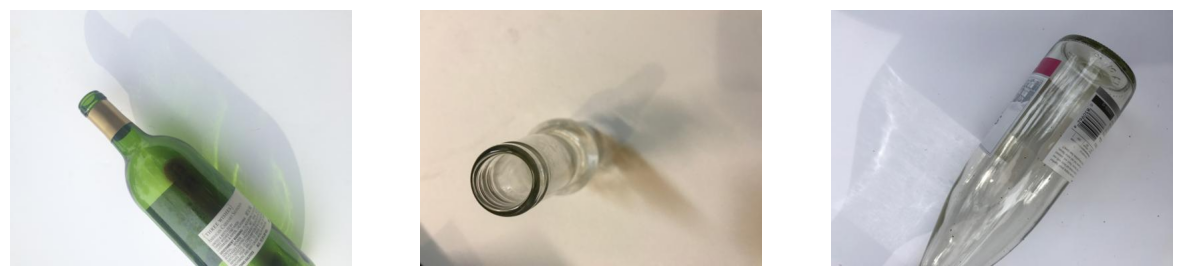

Imagens de: dataset/cardboard


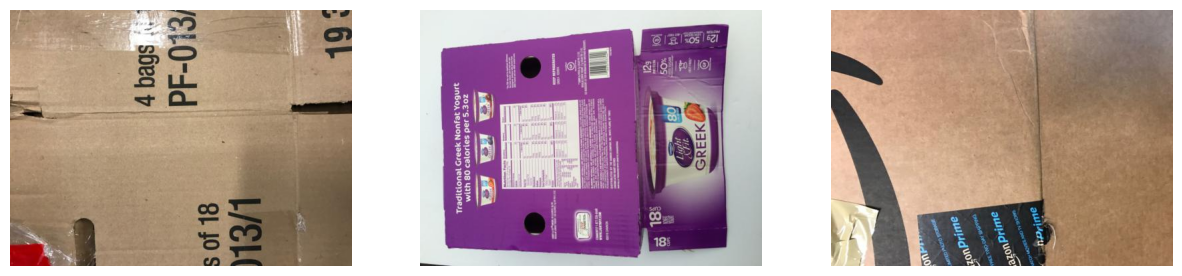

Imagens de: dataset/plastic


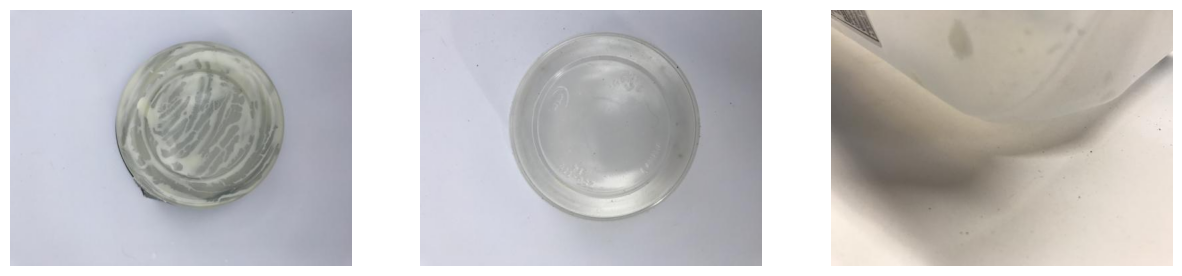

Imagens de: dataset/metal


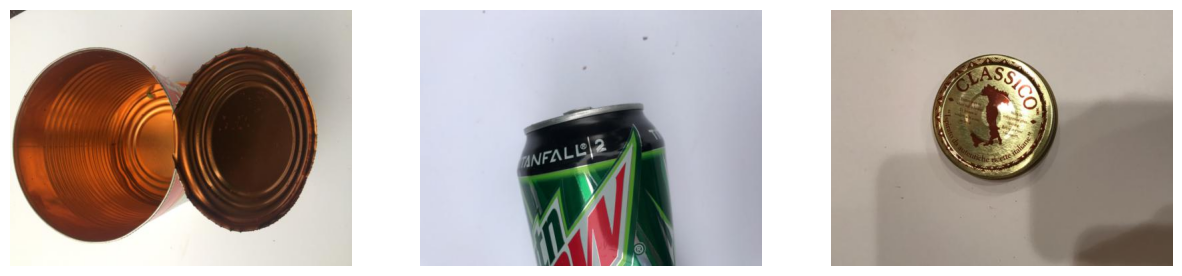

Imagens de: dataset/paper


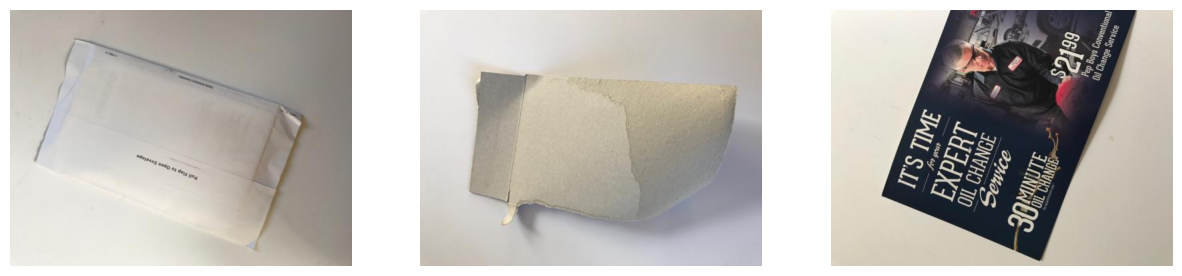

Imagens de: dataset/trash


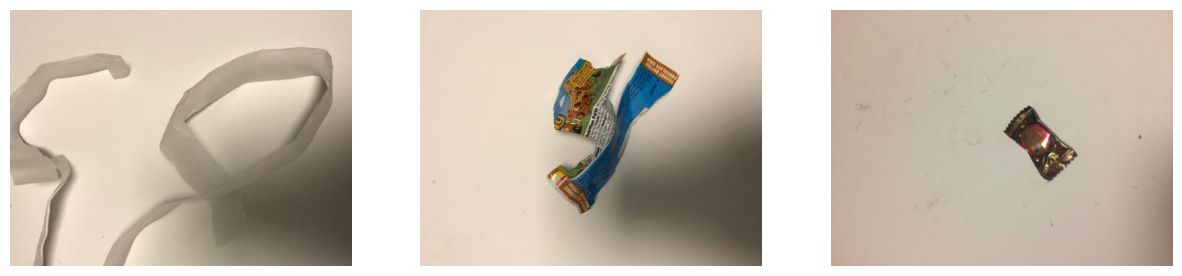

In [8]:
# plotando algumas imagens das classes do dataset 'Trash Type'
def plot_images_from_subfolders(base_dir, num_images=3):
    subfolders = [os.path.join(base_dir, folder) for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

    for folder_path in subfolders:
        print(f"Imagens de: {folder_path}")
        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
        files = os.listdir(folder_path)

        for i in range(num_images):
            img_path = os.path.join(folder_path, files[i])
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].axis('off')
        plt.show()

plot_images_from_subfolders(base_dir, 3)

## Etapa 3: Pré-processamento

Os tópicos que podem ser abordados nesta etapa:
* Definir o tamanho da grade de busca a ser contemplada
* Preparar o conjunto de dados para o treinamento com a estratégia de validação cruzada _holdout_

In [9]:
# Utilizano Keras
param_grid_keras = {
    'units': [32, 64, 128, 256],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'learning_rate': [0.01, 0.1, 0.4],
    'batch_size': [32, 64],
    'epochs': [10, 20, 30]
}

In [10]:
# Preparar o conjunto de dados para o treinamento com a estratégia de validação cruzada holdout
data = []
labels = []

for root, dirs, files in os.walk(base_dir):
  for dir in dirs:
    for file in os.listdir(os.path.join(root, dir)):
      img_path = os.path.join(root, dir, file)
      img = cv2.imread(img_path)
      img = np.array(img)
      label = dir
      data.append(img)
      labels.append(label)

In [11]:
# Organizando algumas informações sobre o conjunto de dados
num_classes = 6
image_shape = data[0].shape

In [12]:
# Preparando a transformação dos rótulos para atributos categóricos utilizando OneHotEncoder
encoder = LabelEncoder()

In [13]:
X = np.array(data)
y = to_categorical(encoder.fit_transform(np.array(labels)))

x_train_temp, x_test, y_train_temp, y_test = train_test_split(X, y, test_size=.3, shuffle=True) # Holdout 70/30
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=.2, shuffle=True) # Holdout 80/20

## Etapa 4: Treinamento e testes dos modelos

Os tópicos que serão abordados nesta etapa:
* Definir qual o modelo que será utilizado e quais arquiteturas serão avaliadas
* Preparar modelo(s) para grade de busca
* Treinamento
* Teste do(s) modelo(s)

In [14]:
class CNNModel(HyperModel):
    def __init__(self, input_shape, num_classes, name=None, tunable=True):
       super().__init__(name, tunable)
       self.input_shape = input_shape
       self.num_classes = num_classes

    def __choice_param(self, param, hp):
      return hp.Choice(param, param_grid_keras[param])

    def build(self, hp):
        model = keras.models.Sequential()

        # Input Layer
        model.add(keras.layers.Input(shape=self.input_shape))

        # Feature Layers
        model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation=self.__choice_param('activation', hp)))
        model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation=self.__choice_param('activation', hp)))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation=self.__choice_param('activation', hp)))
        model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation=self.__choice_param('activation', hp)))
        model.add(keras.layers.GlobalAveragePooling2D())
        model.add(keras.layers.Dropout(0.5))

        # Dense Layers
        model.add(keras.layers.Dense(128, activation=self.__choice_param('activation', hp)))
        model.add(keras.layers.Dense(self.num_classes, activation='softmax'))

        # Preparing model to train
        model.compile(loss = 'categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(learning_rate=self.__choice_param('learning_rate', hp)),
                      metrics=['accuracy'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=self.__choice_param('batch_size', hp),
            **kwargs,
        )

### Treinando

In [15]:
epochs = 100
max_trials = 3
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=3)

Treinamento: Rede customizada

In [16]:
tuner_custom = kt.RandomSearch(
    CNNModel(image_shape, num_classes),
    objective='val_accuracy',
    directory='models/custom',
    overwrite=True,
    max_trials=max_trials)

I0000 00:00:1722206586.288849      24 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722206586.289290      24 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722206586.700232      24 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722206586.700581      24 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [17]:
tuner_custom.search(
    x_train,
    y_train,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping_callback])

Trial 3 Complete [00h 05m 12s]
val_accuracy: 0.2288135588169098

Best val_accuracy So Far: 0.2288135588169098
Total elapsed time: 00h 14m 32s


Treinamento: ResNet

In [18]:
batch_size = 32

In [19]:
tuner_resnet = kt.RandomSearch(
    kt.applications.HyperResNet(input_shape=image_shape, classes=num_classes),
    objective='val_accuracy',
    directory='models/resnet',
    overwrite=True,
    max_trials=max_trials)

In [20]:
tuner_resnet.search(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping_callback])

Trial 3 Complete [00h 06m 45s]
val_accuracy: 0.35593220591545105

Best val_accuracy So Far: 0.35593220591545105
Total elapsed time: 00h 40m 06s


### Recuperando os melhores modelos

In [21]:
def get_best_model(tuner):
  best_models = tuner.get_best_models(num_models=1)
  return best_models[0]

In [22]:
custom_best_model = get_best_model(tuner_custom)
custom_best_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 382, 510, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 380, 508, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 190, 254, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 188, 252, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 186, 250, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,446 (1.06 MB)

 Trainable params: 277,446 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
resnet_best_model = get_best_model(tuner_resnet)
resnet_best_model.summary()

Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 390, 518,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 192, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 192, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 192, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 194, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 96, 128,   │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 96, 128,   │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 96, 128,   │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 96, 128,   │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 96, 128,   │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 96, 128,   │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 96, 128,   │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 96, 128,   │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 96, 128,   │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 96, 128,   │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 96, 128,   │      1,024 │ conv2_block1_3_c

 Total params: 24,729,478 (94.34 MB)

 Trainable params: 24,670,214 (94.11 MB)

 Non-trainable params: 59,264 (231.50 KB)

In [24]:
def print_history_of_model(model):
  history = model.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(x_val, y_val))

  plt.figure(figsize=(6,6))
  plt.plot(history.history['accuracy'], label='acurácia do treinamento')
  plt.plot(history.history['val_accuracy'], label='acurácia da validação')
  plt.title('Histórico de Acurácia')
  plt.xlabel('Épocas')
  plt.ylabel('Acurácia')
  plt.legend()
  plt.show()

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 909ms/step - accuracy: 0.2276 - loss: 1.8418 - val_accuracy: 0.2288 - val_loss: 1.8005
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 845ms/step - accuracy: 0.2008 - loss: 1.8724 - val_accuracy: 0.2288 - val_loss: 1.7629
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 840ms/step - accuracy: 0.1969 - loss: 1.8658 - val_accuracy: 0.2062 - val_loss: 1.7942
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 841ms/step - accuracy: 0.1820 - loss: 1.8321 - val_accuracy: 0.2288 - val_loss: 1.7439
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 838ms/step - accuracy: 0.2090 - loss: 1.7842 - val_accuracy: 0.2288 - val_loss: 1.8006
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 840ms/step - accuracy: 0.2081 - loss: 1.8025 - val_accuracy: 0.1469 - val_loss: 1.8947
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 839ms/step - accuracy: 0.2059 - loss: 1.8920 - val_accuracy: 0.1441 - val_loss: 1.7864
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 840ms/step - accuracy: 0.2037 - loss: 1.8443 - 

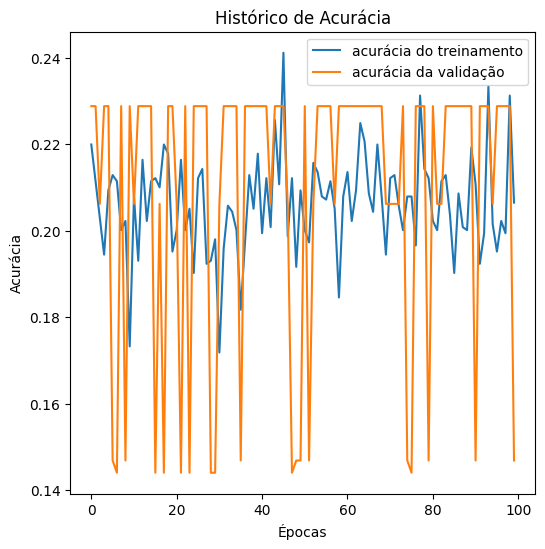

In [25]:
print_history_of_model(custom_best_model)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5454 - loss: 1.2652 - val_accuracy: 0.2288 - val_loss: 4.0217
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5358 - loss: 1.4326 - val_accuracy: 0.4124 - val_loss: 1.8412
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6145 - loss: 1.0740 - val_accuracy: 0.4859 - val_loss: 1.5118
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6143 - loss: 1.0389 - val_accuracy: 0.3785 - val_loss: 2.2015
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6537 - loss: 0.9599 - val_accuracy: 0.4520 - val_loss: 3.1821
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6799 - loss: 0.8769 - val_accuracy: 0.2401 - val_loss: 9.4593
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6086 - loss: 1.2685 - val_accuracy: 0.5311 - val_loss: 1.8194
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6643 - loss: 0.9391 - val_accuracy: 0.4520 - 

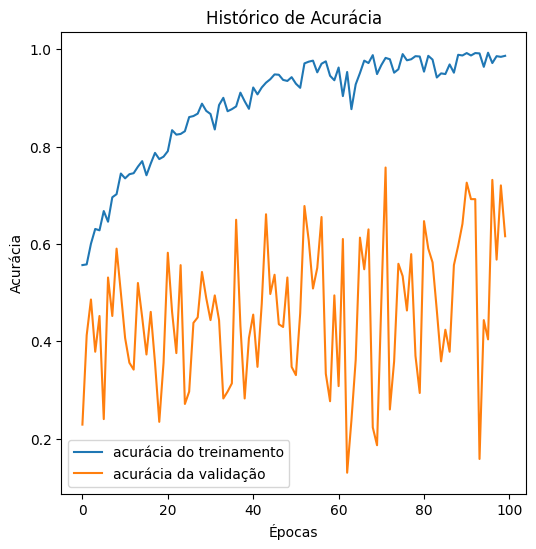

In [26]:
print_history_of_model(resnet_best_model)

### Salvando os modelos

In [27]:
custom_best_model.save('model_custom.keras')

In [28]:
resnet_best_model.save('model_resnet.keras')

## Etapa 5: Análise quantitativa e qualitativa de desempenho dos modelos avaliados

Os tópicos que podem ser abordados nesta etapa:
* Análise quantitativa do(s) modelo(s)
* Análise qualitativa do(s) modelo(s)
* Conclusão. Incluir na dissertação:
  * Sugestões de melhoria;
  * Desafios;
  * Próximos passos.

### Avaliando a qualidade dos modelos

In [29]:
# Função de avaliação
def show_metrics(y_true, y_pred):
    # Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.title('Matriz de Confusão')
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
    plt.show()

    # Acurácia
    acc = accuracy_score(y_true, y_pred)
    print(f"\nAcurácia: {acc:.4f}")

    # F1-Score
    f_score = f1_score(y_true, y_pred, average='weighted')
    print(f"F1-Score: {f_score:.4f}")

    # Precisão
    precision = precision_score(y_true, y_pred, average='weighted')
    print(f"Precisão: {precision:.4f}")

    # Revocação
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"Revocação: {recall:.4f}")

def load_and_predict(model_path, x_test):
    model = keras.models.load_model(model_path)
    y_pred = model.predict(x_test)
    return np.argmax(y_pred, axis=1)

def evaluate_model(model_name, y_test_classes, y_pred):
    print(f"Métricas do {model_name}:")
    show_metrics(y_test_classes, y_pred)

In [30]:
# Carregar e prever usando os modelos
y_pred_custom = load_and_predict('model_custom.keras', x_test)
y_pred_resnet = load_and_predict('model_resnet.keras', x_test)

# Converter y_test para classes
y_test_classes = np.argmax(y_test, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 796ms/step


Métricas do Modelo Custom:


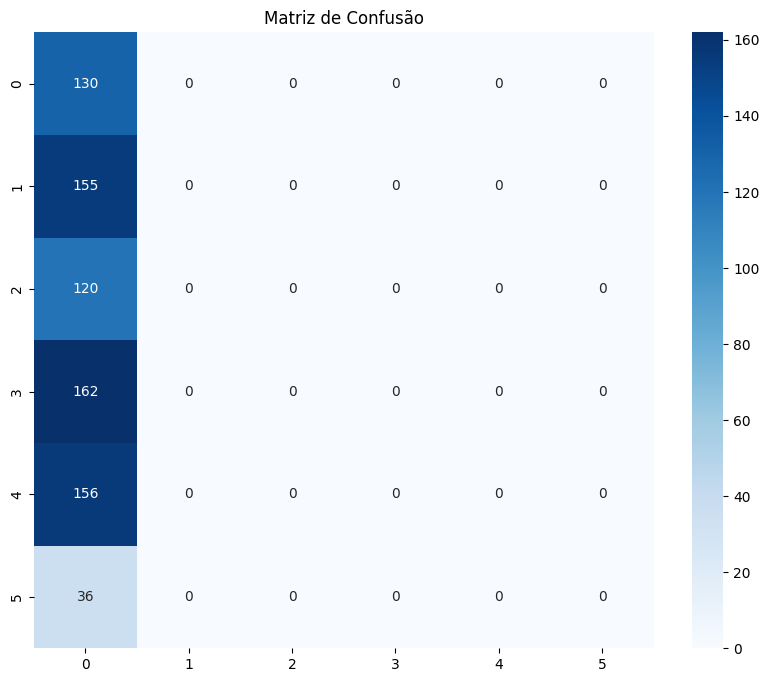


Acurácia: 0.1713
F1-Score: 0.0501
Precisão: 0.0293
Revocação: 0.1713


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
evaluate_model("Modelo Custom", y_test_classes, y_pred_custom)

Métricas do Modelo ResNet:


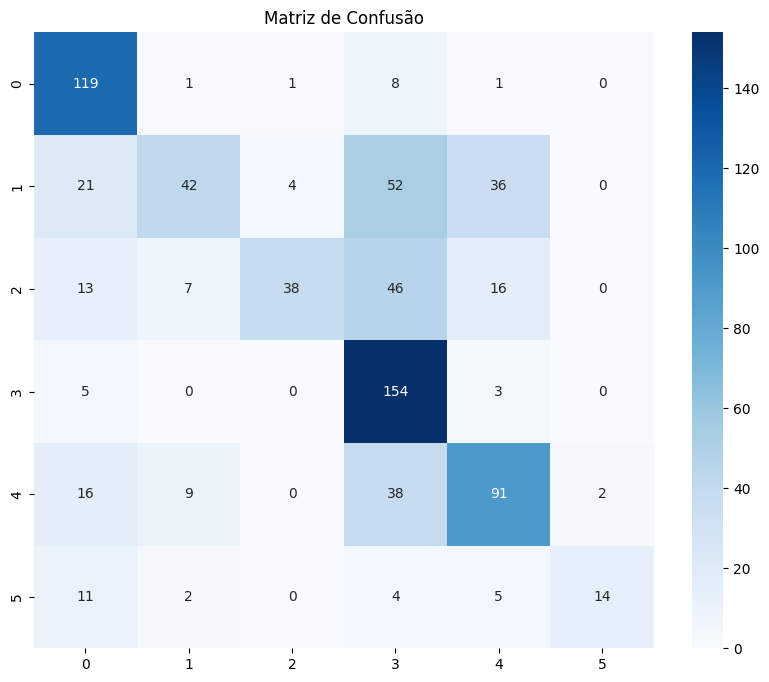


Acurácia: 0.6034
F1-Score: 0.5712
Precisão: 0.6639
Revocação: 0.6034


In [32]:
evaluate_model("Modelo ResNet", y_test_classes, y_pred_resnet)

## Conclusão

#### Métricas utilizadas

##### **Acurácia:** A acurácia representa a proporção de previsões corretas entre todas as previsões realizadas.

\begin{equation}
  \text{Acurácia} = \frac{TP + TN}{TP + TN + FP + FN}
\end{equation}

&nbsp;

##### **Precisão:** A precisão mede a proporção de verdadeiros positivos entre todos os exemplos classificados como positivos pelo modelo.

\begin{equation}
  \text{Precisão} = \frac{TP}{TP + FP}
\end{equation}

&nbsp;

##### **Revocação:** A revocação indica a capacidade do modelo de identificar corretamente todos os exemplos positivos.

\begin{equation}
  \text{Revocação} = \frac{TP}{TP + FN}
\end{equation}

&nbsp;

##### **F1 Score:** O F1-Score é a média harmônica entre precisão e revocação, oferecendo um balanço entre essas duas métricas.

\begin{equation}
  \text{F1} = \frac{2 \times {TP}}{2 \times {TP + FP + FN}}
\end{equation}

&nbsp;

#### Análise de desempenho - Modelo Custom

*   Acurácia: 17,13%
*   Precisão: 2,93%
*   Revocação: 17,13%
*   F1 Score: 5,01%

As métricas indicam que o modelo atual apresenta problemas significativos em seu algoritmo de classificação. Na matriz de confusão, é possível perceber que todos os testes foram classificados na classe 0.

&nbsp;

#### Análise de desempenho - Modelo ResNet

*   Acurácia: 60,34%
*   Precisão: 57,12%
*   Revocação: 66,39%
*   F1 Score: 60,34%

O modelo ResNet, com bases nessas métricas, está mostrando um desempenho moderado, com espaço para melhorias. É possível notar na matriz de confusão que as classes 0 e 3 obtiveram uma boa acurácia, porém as classes restantes deixaram a desejar nesse quesito.

&nbsp;

#### Desafios enfrentados

*   Existe um desequilíbrio da quantidade de exemplos para cada classe
*   O Modelo Customizado não conseguiu classificar adequadamente os objetos
*   O Modelo ResNet teve dificuldade em classificar objetos da classe 1, 2 e 5

#### Sugestões de melhorias

*   Modificar a arquitetura dos modelos para alcançar métricas com valores mais adequados para melhor precisão na identificação de resíduos
*   Realizar um balanceamento da quantidade de exemplos para cada classe

#### Próximos passos

* Refatorar a arquitetura dos modelos
* Realizar novos treinamentos dos modelos